In [1]:
import time
import random
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from pycoral.utils.edgetpu import make_interpreter
from pycoral.adapters import classify
from pycoral.adapters import common

import tflite_runtime.interpreter as tflite
from imgaug import augmenters as img_aug

from lane_navigation.image_augmentation import random_augment


In [2]:
def my_imread(image_path):
    image = cv2.imread(str(image_path))
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    return image


def img_preprocess(image):
    height, _, _ = image.shape
    image = image[
        int(height / 2) :, :, :
    ]  # remove top half of the image, as it is not relavant for lane following
    image = cv2.cvtColor(
        image, cv2.COLOR_RGB2YUV
    )  # Nvidia model said it is best to use YUV color space
    image = cv2.GaussianBlur(image, (3, 3), 0)
    image = cv2.resize(image, (200, 66))  # input image size (200,66) Nvidia model
    # image = image / 255 # normalizing, the processed image becomes black for some reason.  do we need this?
    image = image.astype(np.uint8)
    return image


def image_data_generator(image_paths, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering_angles = []

        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            if is_training:
                # training: augment image
                image, steering_angle = random_augment(image, steering_angle)

            image = img_preprocess(image)
            batch_images.append(image)

        yield np.asarray(batch_images)


def set_input_tensor(interpreter, input):
    input_details = interpreter.get_input_details()[0]
    tensor_index = input_details["index"]
    input_tensor = interpreter.tensor(tensor_index)()
    # Inputs for the TFLite model must be uint8, so we quantize our input data.
    scale, zero_point = input_details["quantization"]
    quantized_input = np.uint8(input / scale + zero_point)
    input_tensor[:, :, :] = quantized_input


def predict_steer(interpreter, input):
    set_input_tensor(interpreter, input)
    interpreter.invoke()
    output_details = interpreter.get_output_details()[0]
    output = interpreter.get_tensor(output_details["index"])
    # Outputs from the TFLite model are uint8, so we dequantize the results:
    scale, zero_point = output_details["quantization"]
    output = scale * (output - zero_point)
    return output


In [3]:
image_paths = []
lab_dirs = list(Path("train_data_generation/data/drive_with_keypress/").glob("*"))
for lab_dir in lab_dirs:
    frame_paths = list(lab_dir.glob("*.png"))
    for frame_path in frame_paths:
        image_paths.append(frame_path)
image_paths.sort()


In [16]:
lane_nav_model_path = Path("lane_navigation/model/lane_navigation_w_pretrain_final.h5")
lane_nav_model = tf.keras.models.load_model(lane_nav_model_path)


In [17]:
def representative_data_gen():
    batch_size = 4
    input_data = tf.cast(
        next(image_data_generator(image_paths, batch_size, False)), dtype=tf.float32
    )
    yield [input_data]


converter = tf.lite.TFLiteConverter.from_keras_model(lane_nav_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.int8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

lane_nav_tflite_model = converter.convert()

with open("lane_navigation/model/lane_navigation_w_pretrain_final.tflite", "wb") as f:
    f.write(lane_nav_tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmpfoa4bhfs/assets


INFO:tensorflow:Assets written to: /tmp/tmpfoa4bhfs/assets
2022-10-24 11:38:42.764472: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2022-10-24 11:38:42.764501: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2022-10-24 11:38:42.764635: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpfoa4bhfs
2022-10-24 11:38:42.766086: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2022-10-24 11:38:42.766097: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/tmpfoa4bhfs
2022-10-24 11:38:42.771179: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2022-10-24 11:38:42.817570: I tensorflow/cc/saved_model/loader.cc:194] Running initialization op on SavedModel bundle at path: /tmp/tmpfoa4bhfs
2022-10-24 11:38:42.832127: I tensorflow/cc/saved_model/loader.cc:283] SavedMode

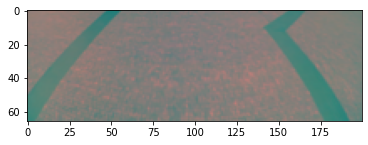

In [25]:
image = cv2.imread(
    "train_data_generation/data/drive_with_keypress/5/frame_000016_102.png"
)
# image = cv2.imread(
#     "train_data_generation/data/drive_with_keypress/8/frame_000027_60.png"
# )
# image = cv2.imread(
#     "train_data_generation/data/drive_with_keypress/9/frame_000001_91.png"
# )
# image = cv2.imread(
#     "train_data_generation/data/drive_with_keypress/28/frame_000017_90.png"
# )

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

proc_image = np.asarray([img_preprocess(image)])

plt.imshow(proc_image[0])


In [26]:
lane_nav_model.predict(proc_image)[0]

array([117.09468], dtype=float32)

In [27]:
interpreter = tflite.Interpreter(
    model_path="lane_navigation/model/lane_navigation_w_pretrain_final.tflite"
)
interpreter.allocate_tensors()

predict_steer(interpreter, proc_image)


array([[111.76535824]])

In [28]:
interpreter = make_interpreter(
    "lane_navigation/model/lane_navigation_w_pretrain_final.tflite"
)
interpreter.allocate_tensors()

predict_steer(interpreter, proc_image)


array([[111.76535824]])

: 